### Imports

In [2]:
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib as mpl
# from pyeto import fao
import numpy as np
import scipy.stats as stats

In [3]:
# Read in the HCDN boundaries
hcdn_boundaries = gpd.read_file('../data/geodata/ucrb_selected_basins.geojson')
hcdn_boundaries=hcdn_boundaries.set_crs(epsg=32613,allow_override=True)

ucrb_boundary = gpd.read_file('../data/geodata/Upper_Colorado_River_Basin_Boundary.json')
ucrb_boundary=ucrb_boundary.to_crs(epsg=32613)


### PPT Data

In [4]:
# Open PRISM precipitation data
prism_ppt = rxr.open_rasterio('../data/precipdata/prism_4km_ucrb.nc')
# convert crs to match the UCRB boundary
# prism_ppt = prism_ppt.rio.reproject(4326)
prism_ppt = prism_ppt.where(prism_ppt>=0,drop=True)
hcdn_prism_ppt = prism_ppt.rio.clip(hcdn_boundaries.geometry)

In [5]:
ucrb_spring_ppt = prism_ppt.where((prism_ppt.month.dt.month>=3) & (prism_ppt.month.dt.month<=5),drop=True).groupby('month.year').sum('month').sel(year=slice(1964,2022))
ucrb_spring_ppt.name = 'ppt'

In [6]:
hcdn_prism_ppt.name = 'ppt'
# get water year precipitation totals
hcdn_prism_ppt_wy = hcdn_prism_ppt.copy()
hcdn_prism_ppt_wy['WY'] = hcdn_prism_ppt_wy.month.dt.year.where(hcdn_prism_ppt_wy.month.dt.month < 10, hcdn_prism_ppt_wy.month.dt.year + 1)
hcdn_prism_ppt_wy = hcdn_prism_ppt_wy.where(hcdn_prism_ppt_wy>=0,np.nan)
hcdn_prism_ppt_wy = hcdn_prism_ppt_wy.groupby('WY').sum('month')
# replace 0 with nan
hcdn_prism_ppt_wy = hcdn_prism_ppt_wy.where(hcdn_prism_ppt_wy>0,np.nan)


In [7]:
# get seasonal precipitation totals
hcdn_prism_ppt_spring = hcdn_prism_ppt.where(hcdn_prism_ppt.month.dt.month.isin([3,4,5]),drop=True).groupby('month.year').sum(dim='month').sel(year=slice(1964,2022))
hcdn_prism_ppt_summer = hcdn_prism_ppt.where(hcdn_prism_ppt.month.dt.month.isin([6,7,8]),drop=True).groupby('month.year').sum(dim='month').sel(year=slice(1964,2022))
hcdn_prism_ppt_fall = hcdn_prism_ppt.where(hcdn_prism_ppt.month.dt.month.isin([9,10,11]),drop=True).groupby('month.year').sum(dim='month').sel(year=slice(1964,2022))
hcdn_prism_ppt_winter = hcdn_prism_ppt.where(hcdn_prism_ppt.month.dt.month.isin([12,1,2]),drop=True).groupby('month.year').sum(dim='month').sel(year=slice(1964,2022))

hcdn_prism_ppt_spring = hcdn_prism_ppt_spring.where(hcdn_prism_ppt_spring>0,drop=True)
hcdn_prism_ppt_summer = hcdn_prism_ppt_summer.where(hcdn_prism_ppt_summer>0,drop=True)
hcdn_prism_ppt_fall = hcdn_prism_ppt_fall.where(hcdn_prism_ppt_fall>0,drop=True)
hcdn_prism_ppt_winter = hcdn_prism_ppt_winter.where(hcdn_prism_ppt_winter>0,drop=True)

### PET Data

In [8]:
# ERA5 PET
era5_et = xr.open_dataset('../data/etdata/ERA5_pet_et_clouds.nc')
era5_et = era5_et.rio.write_crs(4326)
# reproject to 32613
era5_et = era5_et.rio.reproject(32613)
era5_et = era5_et.rio.clip(ucrb_boundary.geometry)
# convert e and pev to mm/month from -1 * m/day by multiplying by days in each month
era5_et['month_days'] = era5_et.time.dt.days_in_month
era5_et['e'] = era5_et['e'] * era5_et['month_days'] * 1000 * -1
era5_et['pev'] = era5_et['pev'] * era5_et['month_days'] * 1000 * -1

In [9]:
# CRU PET
cru_et = xr.open_dataset('../data/etdata/CRU_UCRB_Monthly_PET_1963_2022.nc')
cru_et = cru_et.rio.write_crs(4326)
# reproject to 32613
cru_et = cru_et.rio.reproject(32613)
# clip to HCDN boudnaries
hcdn_cru_et = cru_et.rio.clip(hcdn_boundaries.geometry)
hcdn_cru_et = hcdn_cru_et.where(hcdn_cru_et>0,np.nan)

In [10]:
# ERA5 energy only PET
era5_ee_et = xr.open_dataset('../data/etdata/ERA5_energy_only_clipped.nc')
era5_ee_et = era5_ee_et.rio.write_crs(4326)
# reproject to 32613
era5_ee_et = era5_ee_et.rio.reproject(32613)
# clip to HCDN boudnaries
hcdn_era5_ee_et = era5_ee_et.rio.clip(ucrb_boundary.geometry)
hcdn_era5_ee_et = hcdn_era5_ee_et.where(hcdn_era5_ee_et>0,np.nan)

In [12]:
# ERA5 land Priestley-Taylor PET
era5_pt_et = xr.open_dataset('../data/etdata/ERA5-Land-PT-PET.nc')
era5_pt_et = era5_pt_et.rio.write_crs(4326)
# reproject to 32613
era5_pt_et = era5_pt_et.rio.reproject(32613)
# clip to HCDN boudnaries
hcdn_era5_pt_et = era5_pt_et.rio.clip(ucrb_boundary.geometry)
hcdn_era5_pt_et = hcdn_era5_pt_et.where(hcdn_era5_pt_et>0,np.nan)

In [13]:
# GLEAM PET
if not os.path.exists('../data/etdata/GLEAM_UCRB_1980-2022.nc'):
    # Read in the UCRB boundary
    ucrb_boundary = gpd.read_file('../data/geodata/Upper_Colorado_River_Basin_Boundary.json')
    ucrb_boundary_4326 = ucrb_boundary.copy()
    gleam_et = xr.open_dataset('../data/etdata/Ep_1980-2022_GLEAM_v3.8a_MO.nc')
    # remame lat and lon to y and x
    gleam_et = gleam_et.rename({'lat':'y','lon':'x'})
    gleam_et = gleam_et.rio.write_crs(4326)
    # clip to UCRB boundary
    gleam_et = gleam_et.rio.clip(ucrb_boundary_4326.geometry)
    gleam_et.to_netcdf('../data/etdata/GLEAM_UCRB_1980-2022.nc')
else:
    hcdn_gleam_et = xr.open_dataset('../data/etdata/GLEAM_UCRB_1980-2022.nc')
    hcdn_gleam_et = hcdn_gleam_et.rio.write_crs(4326)
    # reporoject to 32613
    hcdn_gleam_et = hcdn_gleam_et.rio.reproject(32613)
    hcdn_gleam_et = hcdn_gleam_et.rio.clip(ucrb_boundary.geometry)
    hcdn_gleam_et = hcdn_gleam_et.where(hcdn_gleam_et>-10,np.nan)
    hcdn_gleam_et['month_days'] = hcdn_gleam_et.time.dt.days_in_month
    # convert Ep from mm/day to mm/month
    # hcdn_gleam_et['Ep'] = hcdn_gleam_et['Ep'] * hcdn_gleam_et['month_days']


In [14]:
# P-LSH ET
dates = pd.date_range(start='1982-1-1',end='2013-12-31',freq='M')
p_lsh_et = xr.open_mfdataset('../data/etdata/P-LSH_ET/UCRB_Monthly_ET_*.nc',concat_dim='time',combine='nested')
# drop spatial_ref
p_lsh_et['time'] = dates
# add crs
p_lsh_et = p_lsh_et.rio.write_crs(4326)
# reproject to 32613
p_lsh_et = p_lsh_et.rio.reproject(32613)
# clip to HCDN boundaries
p_lsh_et = p_lsh_et.rio.clip(ucrb_boundary.geometry)

#### Calculate seasonal PET

In [62]:
def seasonal_pet(ds, months, variable):
    if variable is None:
        pet = ds.where(ds['time'].dt.month.isin(months),drop=True).groupby('time.year').sum('time')
        pet = pet.where(pet>0,np.nan)
    else:
        # calculate the seasonal PET for each year
        pet = ds.where(ds['time'].dt.month.isin(months),drop=True).groupby('time.year').sum('time')[variable]
        pet = pet.where(pet>0,np.nan)
    return pet
# calculate the spring totals for each year
era5_et_spring = seasonal_pet(era5_et, [3,4,5], 'pev').sel(year=slice(1964,2022))
cru_et_spring = seasonal_pet(hcdn_cru_et, [3,4,5], 'pet').sel(year=slice(1964,2022))
era5_ee_et_spring = seasonal_pet(hcdn_era5_ee_et, [3,4,5], 'et_eo_zero').sel(year=slice(1964,2022))
era5_pt_et_spring = seasonal_pet(hcdn_era5_pt_et, [3,4,5], 'pet_pt').sel(year=slice(1964,2022))
gleam_et_spring = seasonal_pet(hcdn_gleam_et, [3,4,5], 'Ep') # 1980-2022
p_lsh_et_spring = seasonal_pet(p_lsh_et, [3,4,5], 'monthly_ET') # 1982-2013

# calculate the summer totals for each year
era5_et_summer = seasonal_pet(era5_et, [6,7,8], 'pev').sel(year=slice(1964,2022))
cru_et_summer = seasonal_pet(hcdn_cru_et, [6,7,8], 'pet').sel(year=slice(1964,2022))
era5_ee_et_summer = seasonal_pet(hcdn_era5_ee_et, [6,7,8], 'et_eo_zero').sel(year=slice(1964,2022))
era5_pt_et_summer = seasonal_pet(hcdn_era5_pt_et, [6,7,8], 'pet_pt').sel(year=slice(1964,2022))
gleam_et_summer = seasonal_pet(hcdn_gleam_et, [6,7,8], 'Ep') # 1980-2022
p_lsh_et_summer = seasonal_pet(p_lsh_et, [6,7,8], 'monthly_ET') # 1982-2013

# calculate the fall totals for each year
era5_et_fall = seasonal_pet(era5_et, [9,10,11], 'pev').sel(year=slice(1964,2021))
cru_et_fall = seasonal_pet(hcdn_cru_et, [9,10,11], 'pet').sel(year=slice(1964,2021))
era5_ee_et_fall = seasonal_pet(hcdn_era5_ee_et, [9,10,11], 'et_eo_zero').sel(year=slice(1964,2021))
era5_pt_et_fall = seasonal_pet(hcdn_era5_pt_et, [9,10,11], 'pet_pt').sel(year=slice(1964,2021))
gleam_et_fall = seasonal_pet(hcdn_gleam_et, [9,10,11], 'Ep') # 1980-2022
p_lsh_et_fall = seasonal_pet(p_lsh_et, [9,10,11], 'monthly_ET') # 1982-2013

# calculate the winter totals for each year
era5_et_winter = seasonal_pet(era5_et, [12,1,2], 'pev').sel(year=slice(1964,2022))
cru_et_winter = seasonal_pet(hcdn_cru_et, [12,1,2], 'pet').sel(year=slice(1964,2022))
era5_ee_et_winter = seasonal_pet(hcdn_era5_ee_et, [12,1,2], 'et_eo_zero').sel(year=slice(1964,2022))
era5_pt_et_winter = seasonal_pet(hcdn_era5_pt_et, [12,1,2], 'pet_pt').sel(year=slice(1964,2022))
gleam_et_winter = seasonal_pet(hcdn_gleam_et, [12,1,2], 'Ep') # 1980-2022
p_lsh_et_winter = seasonal_pet(p_lsh_et, [12,1,2], 'monthly_ET') # 1982-2013

Text(0.5, 1.0, 'Winter PET')

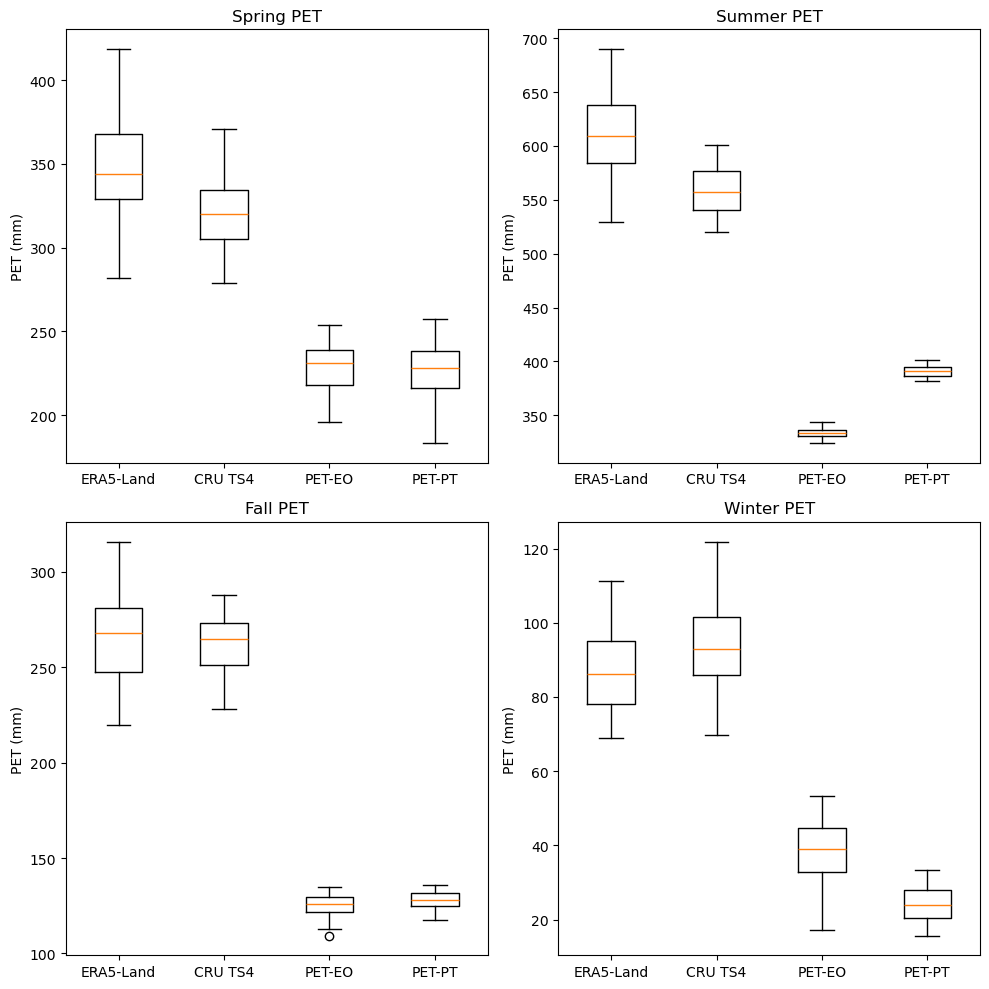

In [63]:
# calcuye the spatial mean across the basins and plot boxplots for each data type and season
era5_et_spring_mean = era5_et_spring.mean(dim=['y','x'])
cru_et_spring_mean = cru_et_spring.mean(dim=['y','x'])
era5_ee_et_spring_mean = era5_ee_et_spring.mean(dim=['y','x'])
era5_pt_et_spring_mean = era5_pt_et_spring.mean(dim=['y','x'])
gleam_et_spring_mean = (gleam_et_spring.mean(dim=['y','x']))
p_lsh_et_spring_mean = p_lsh_et_spring.mean(dim=['y','x'])

era5_et_summer_mean = era5_et_summer.mean(dim=['y','x'])
cru_et_summer_mean = cru_et_summer.mean(dim=['y','x'])
era5_ee_et_summer_mean = era5_ee_et_summer.mean(dim=['y','x'])
era5_pt_et_summer_mean = era5_pt_et_summer.mean(dim=['y','x'])
gleam_et_summer_mean = (gleam_et_summer.mean(dim=['y','x']))
p_lsh_et_summer_mean = p_lsh_et_summer.mean(dim=['y','x'])

era5_et_fall_mean = era5_et_fall.mean(dim=['y','x'])
cru_et_fall_mean = cru_et_fall.mean(dim=['y','x'])
era5_ee_et_fall_mean = era5_ee_et_fall.mean(dim=['y','x'])
era5_pt_et_fall_mean = era5_pt_et_fall.mean(dim=['y','x'])
gleam_et_fall_mean = (gleam_et_fall.mean(dim=['y','x']))
p_lsh_et_fall_mean = p_lsh_et_fall.mean(dim=['y','x'])

era5_et_winter_mean = era5_et_winter.mean(dim=['y','x'])
cru_et_winter_mean = cru_et_winter.mean(dim=['y','x'])
era5_ee_et_winter_mean = era5_ee_et_winter.mean(dim=['y','x'])
era5_pt_et_winter_mean = era5_pt_et_winter.mean(dim=['y','x'])
gleam_et_winter_mean = (gleam_et_winter.mean(dim=['y','x']))
p_lsh_et_winter_mean = p_lsh_et_winter.mean(dim=['y','x'])

# plot a boxplot for the spring PET for each dataset
fig, axs = plt.subplots(ncols=2, nrows=2, tight_layout=True, figsize=(10,10))    

ax = axs[0,0]
ax.boxplot([era5_et_spring_mean, cru_et_spring_mean, era5_ee_et_spring_mean, era5_pt_et_spring_mean])
ax.set_xticklabels(['ERA5-Land', 'CRU TS4', 'PET-EO','PET-PT'])
ax.set_ylabel('PET (mm)')
ax.set_title('Spring PET')

ax = axs[0,1]
ax.boxplot([era5_et_summer_mean, cru_et_summer_mean, era5_ee_et_summer_mean, era5_pt_et_summer_mean])
ax.set_xticklabels(['ERA5-Land', 'CRU TS4', 'PET-EO','PET-PT'])
ax.set_ylabel('PET (mm)')
ax.set_title('Summer PET')

ax = axs[1,0]
ax.boxplot([era5_et_fall_mean, cru_et_fall_mean, era5_ee_et_fall_mean, era5_pt_et_fall_mean])
ax.set_xticklabels(['ERA5-Land', 'CRU TS4', 'PET-EO','PET-PT'])
ax.set_ylabel('PET (mm)')
ax.set_title('Fall PET')

ax = axs[1,1]
ax.boxplot([era5_et_winter_mean, cru_et_winter_mean, era5_ee_et_winter_mean, era5_pt_et_winter_mean])
ax.set_xticklabels(['ERA5-Land', 'CRU TS4', 'PET-EO','PET-PT'])
ax.set_ylabel('PET (mm)')
ax.set_title('Winter PET')

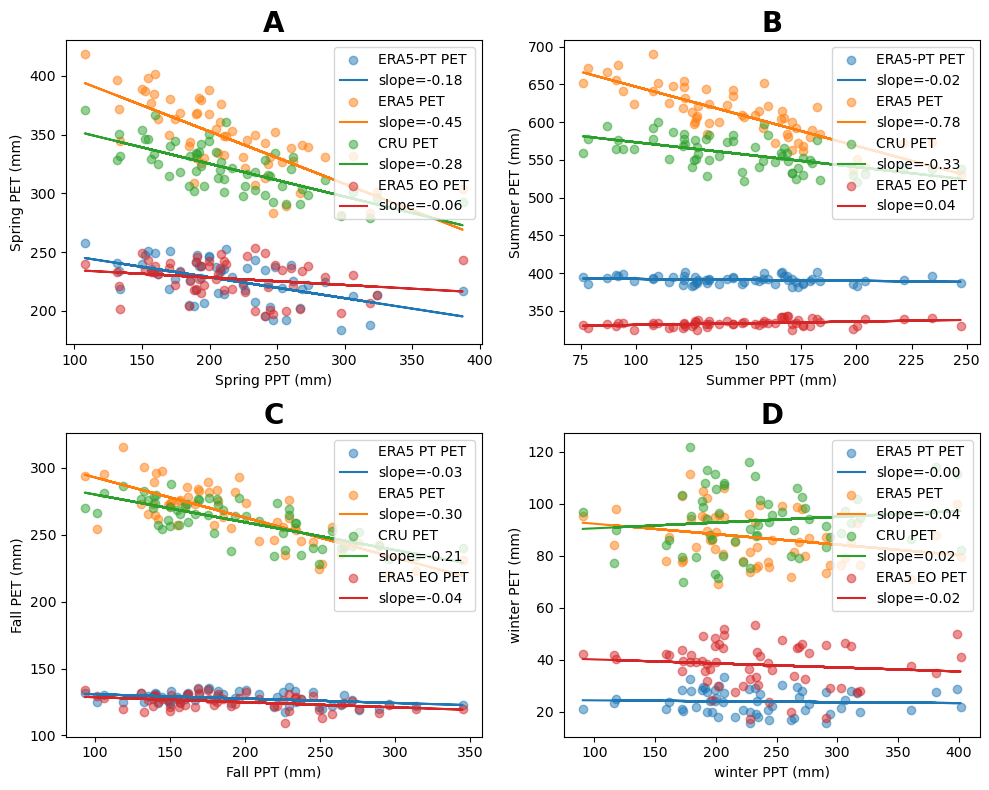

In [64]:
fig, axs = plt.subplots(ncols=2, nrows=2, tight_layout=True, figsize=(10,8))
ax = axs[0,0]
ax.scatter(hcdn_prism_ppt_spring.mean(dim=['x','y']).values,
            era5_pt_et_spring_mean, label='ERA5-PT PET',alpha=0.5)
# add regression line and label with slope
x = hcdn_prism_ppt_spring.mean(dim=['x','y']).values
y = era5_pt_et_spring_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.scatter(hcdn_prism_ppt_spring.mean(dim=['x','y']).values,
            era5_et_spring_mean, label='ERA5 PET',alpha=0.5)
x = hcdn_prism_ppt_spring.mean(dim=['x','y']).values
y = era5_et_spring_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.scatter(hcdn_prism_ppt_spring.mean(dim=['x','y']).values,
            cru_et_spring_mean, label='CRU PET',alpha=0.5)
x = hcdn_prism_ppt_spring.mean(dim=['x','y']).values
y = cru_et_spring_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.scatter(hcdn_prism_ppt_spring.mean(dim=['x','y']).values,
            era5_ee_et_spring_mean, label='ERA5 EO PET',alpha=0.5)
x = hcdn_prism_ppt_spring.mean(dim=['x','y']).values
y = era5_ee_et_spring_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.set_xlabel('Spring PPT (mm)')
ax.set_ylabel('Spring PET (mm)')
ax.legend()

# summer
ax = axs[0,1]
ax.scatter(hcdn_prism_ppt_summer.mean(dim=['x','y']).values,
            era5_pt_et_summer_mean, label='ERA5-PT PET',alpha=0.5)
# add regression line and label with slope
x = hcdn_prism_ppt_summer.mean(dim=['x','y']).values
y = era5_pt_et_summer_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.scatter(hcdn_prism_ppt_summer.mean(dim=['x','y']).values,
            era5_et_summer_mean, label='ERA5 PET',alpha=0.5)
x = hcdn_prism_ppt_summer.mean(dim=['x','y']).values
y = era5_et_summer_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.scatter(hcdn_prism_ppt_summer.mean(dim=['x','y']).values,
            cru_et_summer_mean, label='CRU PET',alpha=0.5)
x = hcdn_prism_ppt_summer.mean(dim=['x','y']).values
y = cru_et_summer_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.scatter(hcdn_prism_ppt_summer.mean(dim=['x','y']).values,
            era5_ee_et_summer_mean, label='ERA5 EO PET',alpha=0.5)
x = hcdn_prism_ppt_summer.mean(dim=['x','y']).values
y = era5_ee_et_summer_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.set_xlabel('Summer PPT (mm)')
ax.set_ylabel('Summer PET (mm)')
ax.legend()

# fall
ax = axs[1,0]
ax.scatter(hcdn_prism_ppt_fall.mean(dim=['x','y']).sel(year=slice(1964,2021)).values,
            era5_pt_et_fall_mean, label='ERA5 PT PET',alpha=0.5)
# add regression line and label with slope
x = hcdn_prism_ppt_fall.mean(dim=['x','y']).sel(year=slice(1964,2021)).values
y = era5_pt_et_fall_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.scatter(hcdn_prism_ppt_fall.mean(dim=['x','y']).sel(year=slice(1964,2021)).values,
            era5_et_fall_mean, label='ERA5 PET',alpha=0.5)
x = hcdn_prism_ppt_fall.mean(dim=['x','y']).sel(year=slice(1964,2021)).values
y = era5_et_fall_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.scatter(hcdn_prism_ppt_fall.mean(dim=['x','y']).sel(year=slice(1964,2021)).values,
            cru_et_fall_mean, label='CRU PET',alpha=0.5)
x = hcdn_prism_ppt_fall.mean(dim=['x','y']).sel(year=slice(1964,2021)).values
y = cru_et_fall_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.scatter(hcdn_prism_ppt_fall.mean(dim=['x','y']).sel(year=slice(1964,2021)).values,
            era5_ee_et_fall_mean, label='ERA5 EO PET',alpha=0.5)
x = hcdn_prism_ppt_fall.mean(dim=['x','y']).sel(year=slice(1964,2021)).values
y = era5_ee_et_fall_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.set_xlabel('Fall PPT (mm)')
ax.set_ylabel('Fall PET (mm)')
ax.legend()

# winter
ax = axs[1,1]
ax.scatter(hcdn_prism_ppt_winter.mean(dim=['x','y']).values,
            era5_pt_et_winter_mean, label='ERA5 PT PET',alpha=0.5)
# add regression line and label with slope
x = hcdn_prism_ppt_winter.mean(dim=['x','y']).values
y = era5_pt_et_winter_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.scatter(hcdn_prism_ppt_winter.mean(dim=['x','y']).values,
            era5_et_winter_mean, label='ERA5 PET',alpha=0.5)
x = hcdn_prism_ppt_winter.mean(dim=['x','y']).values
y = era5_et_winter_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.scatter(hcdn_prism_ppt_winter.mean(dim=['x','y']).values,
            cru_et_winter_mean, label='CRU PET',alpha=0.5)
x = hcdn_prism_ppt_winter.mean(dim=['x','y']).values
y = cru_et_winter_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
# standard error of the slope
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.scatter(hcdn_prism_ppt_winter.mean(dim=['x','y']).values,
            era5_ee_et_winter_mean, label='ERA5 EO PET',alpha=0.5)
x = hcdn_prism_ppt_winter.mean(dim=['x','y']).values
y = era5_ee_et_winter_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.set_xlabel('winter PPT (mm)')
ax.set_ylabel('winter PET (mm)')
ax.legend()

labels = ['A', 'B', 'C', 'D']
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.set_title(f'{labels[i]}', fontweight='bold', fontsize=20)


In [65]:
cru_et = xr.open_dataset('../data/etdata/CRU_UCRB_Monthly_PET_1963_2022.nc')
# clip to HCDN boudnaries
hcdn_cru_et = cru_et
hcdn_cru_et = hcdn_cru_et.where(hcdn_cru_et>0,np.nan)
# calculate the mean spring PET for the HCDN basins
hcdn_spring_pet_cru = hcdn_cru_et.where(hcdn_cru_et['time'].dt.month.isin([3,4,5]),drop=True).groupby('time.year').sum('time')
hcdn_spring_pet_cru = hcdn_spring_pet_cru.where(hcdn_spring_pet_cru>0,np.nan)
# get the spatial mean of the spring PET for the HCDN basins
hcdn_spring_pet_cru_mean = hcdn_spring_pet_cru.mean(dim=['x','y']).sel(year=slice(1964,2022)).pet

In [133]:
# for each hcdn basin, calculate the average and std of dPET/dPPT for spring
# dpet_dppt_df = pd.DataFrame(index=hcdn_boundaries.STAID.values,
#                             columns=['era5_mean','era5_std','cru_mean','cru_std','gleam_mean','gleam_std', 'era5_ee_mean', 'era5_ee_std'])
dpet_dppt_df = pd.DataFrame(index=hcdn_boundaries.STAID.values,
                            columns=['era5_mean','era5_std', 'era5_pt_mean', 'era5_pt_std','era5_ee_mean', 'era5_ee_std'])
wy_prism_ppt= pd.DataFrame(index=hcdn_prism_ppt_wy.sel(WY=slice(1964,2022)).WY.values,
                          columns=hcdn_boundaries.STAID.values)
spring_prism_ppt = pd.DataFrame(index=hcdn_prism_ppt_spring.sel(year=slice(1964,2022)).year.values,
                            columns=hcdn_boundaries.STAID.values)
spring_pet = pd.DataFrame(index=hcdn_prism_ppt_wy.sel(WY=slice(1964,2022)).WY.values,
                          columns=hcdn_boundaries.STAID.values)
                          
for basin in hcdn_boundaries.STAID:
    b = hcdn_boundaries[hcdn_boundaries.STAID==basin]
    # clip the prism ppt to the basin
    ppt = ucrb_spring_ppt.rio.clip(b.geometry, all_touched=True)
    ppt = ppt.where(ppt>0,drop=True)
    try:
        # clip the PET to the basin for ERA5 and CRU
        era5_pet = era5_et_spring.rio.clip(b.geometry, all_touched=True)
        # cru_pet = cru_et_spring.rio.clip(b.geometry, all_touched=True)
        era5_pt_pet = era5_pt_et_spring.rio.clip(b.geometry, all_touched=True)
        era5_ee_pet = era5_ee_et_spring.rio.clip(b.geometry, all_touched=True)
        # calculate the slope and error of the slope
        x = ppt.mean(dim=['x','y']).values
        wy_prism_ppt[basin] = x
        spring_prism_ppt[basin] = x
        y1 = era5_pet.mean(dim=['x','y']).values
        # y2 = cru_pet.mean(dim=['x','y']).values
        y3 = era5_pt_pet.mean(dim=['x','y']).values
        y4 = era5_ee_pet.mean(dim=['x','y']).values
        spring_pet[basin] = y1

        x = sm.add_constant(x)
       
        model1 = sm.OLS(y1,x)
        results1 = model1.fit()
        slope1 = results1.params[1]
        std_err1 = results1.bse[1]

        # model2 = sm.OLS(y2,x)
        # results2 = model2.fit()
        # slope2 = results2.params[1]
        # std_err2 = results2.bse[1]
        model3 = sm.OLS(y3,x)
        results3 = model3.fit()
        slope3 = results3.params[1]
        std_err3 = results3.bse[1]

        model4 = sm.OLS(y4,x)
        results4 = model4.fit()
        slope4 = results4.params[1]
        std_err4 = results4.bse[1]


    except:
        # get the nearest grid cell to the centroid of the basin
        print(basin)
        ppt = ucrb_spring_ppt.sel(x=b.geometry.centroid.x.values[0],y=b.geometry.centroid.y.values[0],method='nearest')
            
        era5_pet = era5_et_spring.sel(x=b.geometry.centroid.x.values[0],y=b.geometry.centroid.y.values[0],method='nearest')
        if basin == '09312600':
            era5_pet = era5_et_spring.sel(x=b.geometry.centroid.x.values[0],y=b.geometry.centroid.y.values[0],method='bfill')
        # cru_pet = cru_et_spring.dropna(dim='y',how='all').dropna(dim='x',how='all')
        # cru_pet = cru_pet.sel(y=b.geometry.centroid.y.values[0],x=b.geometry.centroid.x.values[0],method='nearest')
        era5_pt_pet = era5_pt_et_spring.sel(x=b.geometry.centroid.x.values[0],y=b.geometry.centroid.y.values[0],method='nearest')
        era5_ee_pet = era5_ee_et_spring.sel(x=b.geometry.centroid.x.values[0],y=b.geometry.centroid.y.values[0],method='nearest')  
       
        # if len(cru_pet) == 0:
        #     cru_pet = cru_et_spring.sel(y=b.geometry.centroid.y.values[0],x=b.geometry.centroid.x.values[0],method='ffill')
        #     if len(cru_pet) == 0:
        #         cru_pet = cru_et_spring.sel(y=b.geometry.centroid.y.values[0],x=b.geometry.centroid.x.values[0],method='bfill')
        # if len(gleam_pet) == 0:
        #     gleam_pet = gleam_et_spring.sel(y=b.geometry.centroid.y.values[0],x=b.geometry.centroid.x.values[0],method='ffill')
        #     if len(gleam_pet) == 0:
        #         gleam_pet = gleam_et_spring.sel(y=b.geometry.centroid.y.values[0],x=b.geometry.centroid.x.values[0],method='bfill')
    
        # caclulate the slope and error of the slope
        x = ppt.values
        wy_prism_ppt[basin] = x
        spring_prism_ppt[basin] = x
        y1 = era5_pet.values
        # y2 = cru_pet.values
        y3 = era5_pt_pet.values
        y4 = era5_ee_pet.values
        spring_pet[basin] = y1


        x = sm.add_constant(x)

        model1 = sm.OLS(y1,x)
        results1 = model1.fit()
        slope1 = results1.params[1]
        std_err1 = results1.bse[1]
        
        # model2 = sm.OLS(y2,x)
        # results2 = model2.fit()
        # slope2 = results2.params[1]
        # std_err2 = results2.bse[1]

        model4 = sm.OLS(y4,x)
        results4 = model4.fit()
        slope4 = results4.params[1]
        std_err4 = results4.bse[1]

        # x = ppt.sel(year=slice(1980,2022)).values
        model3 = sm.OLS(y3,x)
        results3 = model3.fit()
        slope3 = results3.params[1]
        std_err3 = results3.bse[1]


    # dpet_dppt_df.loc[basin] = [slope1, std_err1, slope2, std_err2, slope3, std_err3, slope4, std_err4]
    dpet_dppt_df.loc[basin] = [slope1, std_err1, slope3, std_err3, slope4, std_err4]


In [134]:
low = hcdn_boundaries[hcdn_boundaries['elevation_category']=='low'].STAID.to_list()
mid = hcdn_boundaries[hcdn_boundaries['elevation_category']=='medium'].STAID.to_list()
high = hcdn_boundaries[hcdn_boundaries['elevation_category']=='high'].STAID.to_list()

In [135]:
daily_q = xr.open_dataset('../data/streamflowdata/selected_hcdn_basin_chars_and_daily_q.nc')

In [136]:
q = xr.open_dataset('../data/streamflowdata/selected_hcdn_streamflow_annual.nc')['wy_q_mm']

# calculate the % change during the 2000-2022 period compared to the mean 1964-1999 period
percent_change = 100 *(q-q.sel(water_year=slice(1964,1999)).mean(dim='water_year')) / q.sel(water_year=slice(1964,1999)).mean(dim='water_year')
percent_change_df = percent_change.to_dataframe()
wy_q_perc_change = percent_change_df.reset_index().pivot(index='water_year',columns='site_no',values='wy_q_mm')
wy_prism_ppt_perc_change = 100*(wy_prism_ppt - wy_prism_ppt.loc[1964:1999].mean())/wy_prism_ppt.loc[1964:1999].mean()
pet_anomaly = (spring_pet - spring_pet.loc[1964:1999].mean())/spring_pet.loc[1964:1999].std()

In [137]:
from scipy import interpolate
df = pd.DataFrame([wy_prism_ppt_perc_change.values.flatten(), pet_anomaly.values.flatten(), wy_q_perc_change.values.flatten()]).T
df.columns = ['ppt','pet','q']
# remove nan values
df = df.dropna()
# set up a regular grid of interpolation points
xi, yi = np.mgrid[-100:100:10j, -2:2:10j]
# interpolate
rbf = interpolate.Rbf(df['ppt'], df['pet'], df['q'], function='linear')
zi = rbf(xi, yi)



(-2.0, 2.0)

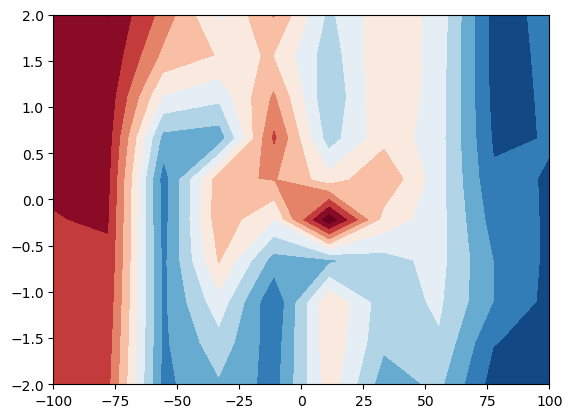

In [138]:
fig, ax = plt.subplots()
ax.contourf(xi, yi, zi, 10, cmap='RdBu', vmin=-50, vmax=50)
ax.set_ylim(-2,2)



In [178]:
order = ['09110000','09109000','09036000','09035900','09035700','09289500','09026500','09352900','09124500',
         '09010500','09196500','09361500','09165000','09112500','09081600','09032000','09365500',
         '09310500','09277500','09255000','09253000','09223000','09059500','09210500','09188500','09166500',
]
order2 = ['09110000','09109000','09289500','09352900',
         '09196500','09361500','09165000','09112500','09081600','09365500',
         '09310500','09277500','09255000','09223000','09210500','09188500','09166500','09253000'
]

In [210]:
# calculate the % change in spring pet during the 2000-2022 period compared to the mean 1964-1999 period
spring_pet_percent_change = (spring_pet.loc[2000:2022].mean()-spring_pet.loc[1964:1999].mean())

# calculate the % change during the 2000-2022 period compared to the mean 1964-1999 period
percent_change = (q.sel(water_year=slice(2000,2022)).mean(axis=0)-q.sel(water_year=slice(1964,1999)).mean(dim='water_year')) 
percent_change_df = percent_change.to_dataframe()['wy_q_mm']

# calculate the value difference in means
spring_ppt = xr.open_dataset('../data/streamflowdata/selected_hcdn_streamflow_annual.nc')['spring_ppt']
winter_ppt = xr.open_dataset('../data/streamflowdata/selected_hcdn_streamflow_annual.nc')['winter_ppt']
spring_ppt_mean = spring_ppt.sel(water_year=slice(2000,2022)).mean(dim='water_year') - spring_ppt.sel(water_year=slice(1964,1999)).mean(dim='water_year').to_dataframe()['spring_ppt']
winter_ppt_mean = winter_ppt.sel(water_year=slice(2000,2022)).mean(dim='water_year') - winter_ppt.sel(water_year=slice(1964,1999)).mean(dim='water_year').to_dataframe()['winter_ppt']

-0.26527370130450795

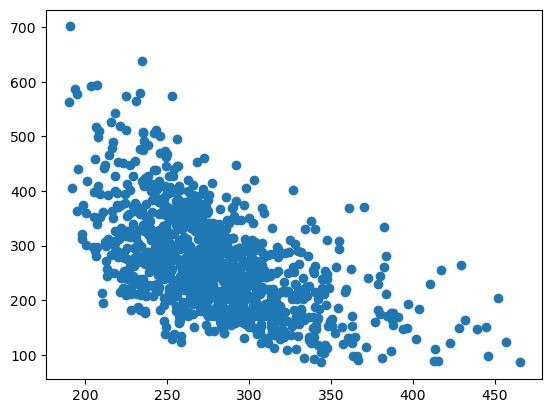

In [208]:
plt.scatter(spring_pet[order2], spring_ppt.to_dataframe().reset_index().pivot(index='water_year',columns='site_no',values='spring_ppt')[order2])
# get the slope of this line
y = spring_pet[order2].values.flatten()

x = spring_ppt.to_dataframe().reset_index().pivot(index='water_year',columns='site_no',values='spring_ppt')[order2].values.flatten()
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
slope

20.841227319432974 14.116257701995204 18.887596836301643
-4.531396092447515 14.143753404075774 16.475445581907003


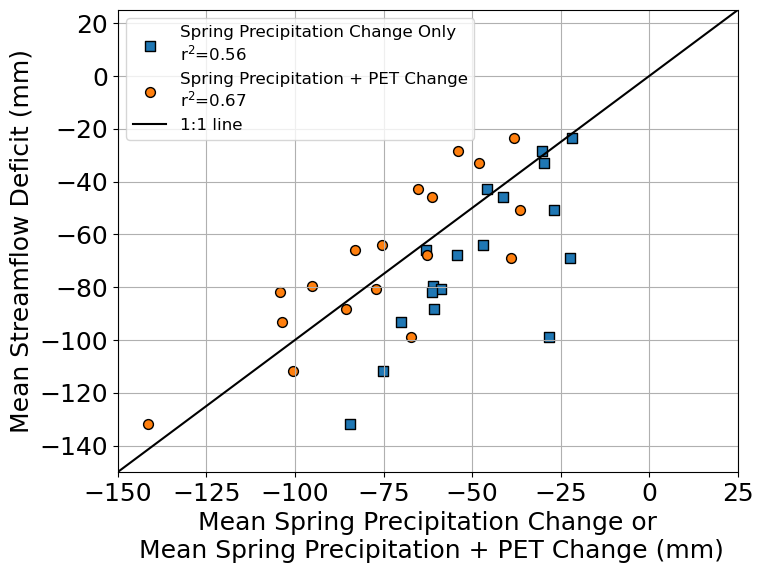

In [211]:
a = (spring_ppt_mean.loc[order2]).to_pandas()
c = (spring_ppt_mean.loc[order2]-spring_pet_percent_change.loc[order2].fillna(0)).to_pandas()
b = percent_change_df.loc[order2]
# make b all negative
# b = b.abs() *-1

fig, ax = plt.subplots(figsize=(8,6))

# add r2 value
x = sm.add_constant(a.values)
model = sm.OLS(b.values,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
# calculate the cumulative bias
cumulative_bias = np.sum(a-b)/len(a)
# calculate the mean absolute error of the data
mae = np.mean(np.abs(results.resid))
# calulate the mean squared error
rmse = np.sqrt(np.mean(results.resid**2))
print(cumulative_bias, mae, rmse)
r2 = results.rsquared
ax.scatter(a,b, label=f'Spring Precipitation Change Only\nr$^2$={r2:.2f}',s=50, ec='k', marker='s')
# plot the best fit line in orange
# ax.plot(a, intercept + slope*a, color='blue')

x = sm.add_constant(c.values)
model = sm.OLS(b.values,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
# calculate the cumulative bias
cumulative_bias = np.sum(c-b)/len(b)
# calculate the mean absolute error of the data
mae = np.mean(np.abs(results.resid))
# calulate the mean squared error
rmse = np.sqrt(np.mean(results.resid**2))
print(cumulative_bias, mae, rmse)

r2 = results.rsquared
# calculate the mean absolute error of the data

ax.scatter(c,b, label=f'Spring Precipitation + PET Change\nr$^2$={r2:.2f}',s=50, ec='k', marker='o')
# plot the best fit line in orange
# ax.plot(c, intercept + slope*c, color='orange')

ax.plot([-150,25],[-150,25],color='black', label='1:1 line')
ax.set_xlabel('Mean Spring Precipitation Change or\n Mean Spring Precipitation + PET Change (mm)', size=18)
ax.set_ylabel('Mean Streamflow Deficit (mm)', size=18)

# ax.set_title('Comparing Significant Streamflow Deficit and Precipitation + Spring PET Change\nfor Selected HCDN Basins since 2000')
ax.legend(loc='upper left', fontsize=12)
# increase font size for the x and y axis labels
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlim(-150,25)
ax.set_ylim(-150,25)
ax.grid()



/tmp/ipykernel_23671/623217443.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(low+mid+high,rotation=90);


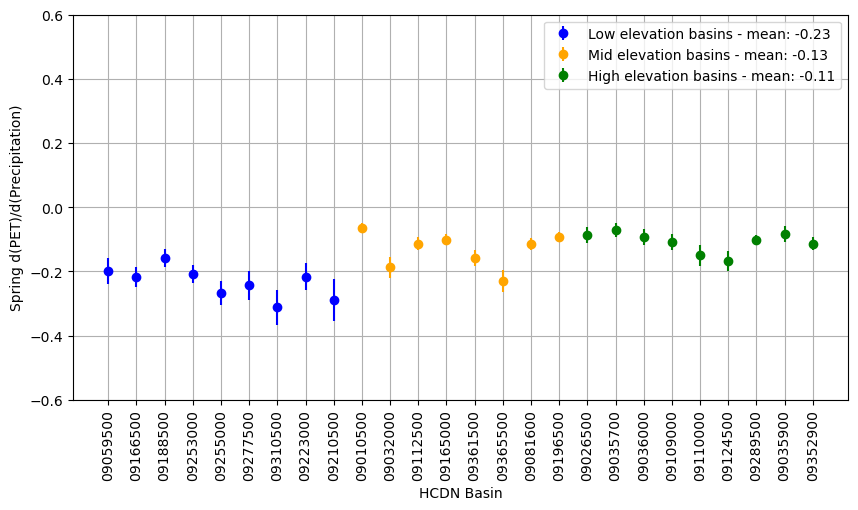

In [212]:
# create a scatter plot of the dPET/dPPT for each basin with the mean values as the point and the std value as the error
fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(dpet_dppt_df.loc[low].index, 
            dpet_dppt_df.loc[low]['era5_pt_mean'], 
            yerr=dpet_dppt_df.loc[low]['era5_pt_std'], 
            label=f"Low elevation basins - mean: {dpet_dppt_df.loc[low]['era5_pt_mean'].mean():.2f}",
            fmt='o', 
            color='blue')
ax.errorbar(dpet_dppt_df.loc[mid].index,
            dpet_dppt_df.loc[mid]['era5_pt_mean'], 
            yerr=dpet_dppt_df.loc[mid]['era5_pt_std'], 
            label=f"Mid elevation basins - mean: {dpet_dppt_df.loc[mid]['era5_pt_mean'].mean():.2f}",
            fmt='o',
            color='orange')
ax.errorbar(dpet_dppt_df.loc[high].index,
            dpet_dppt_df.loc[high]['era5_pt_mean'], 
            yerr=dpet_dppt_df.loc[high]['era5_pt_std'], 
            label=f"High elevation basins - mean: {dpet_dppt_df.loc[high]['era5_pt_mean'].mean():.2f}",
            fmt='o',
            color='green')
# ax.errorbar(dpet_dppt_df.loc[low].index, 
#             dpet_dppt_df.loc[low]['era5_pt_mean'], 
#             yerr=dpet_dppt_df.loc[low]['era5_pt_std'], 
#             label='Low elevation basins',
#             fmt='s', 
#             color='blue')
# ax.errorbar(dpet_dppt_df.loc[mid].index,
#             dpet_dppt_df.loc[mid]['era5_pt_mean'], 
#             yerr=dpet_dppt_df.loc[mid]['era5_pt_std'], 
#             label='Mid elevation basins',
#             fmt='s',
#             color='orange')
# ax.errorbar(dpet_dppt_df.loc[high].index,
#             dpet_dppt_df.loc[high]['era5_pt_mean'], 
#             yerr=dpet_dppt_df.loc[high]['era5_pt_std'], 
#             label='High elevation basins',
#             fmt='s',
#             color='green')
# plot the deficit for each basin on a twin axis
# ax2 = ax.twinx()
# ax2.plot(percent_change_df.loc[low].index,percent_change_df.loc[low].wy_q_mm,color='red',alpha=0.5, ls='-',marker='o')
# ax2.plot(percent_change_df.loc[mid].index,percent_change_df.loc[mid].wy_q_mm,color='red',alpha=0.5, ls='-',marker='o')
# ax2.plot(percent_change_df.loc[high].index,percent_change_df.loc[high].wy_q_mm,color='red',alpha=0.5, ls='-',marker='o')
# # hide the x-axis labels
# ax2.set_xticklabels([])
# ax2.set_ylabel('Percent Change in Streamflow Volumne since 2000(%)')
# ax2.set_ylim(-40,40)

ax.set_ylabel('Spring d(PET)/d(Precipitation)');
ax.set_xlabel('HCDN Basin');
ax.set_xticklabels(low+mid+high,rotation=90);
# add grid
ax.grid()
ax.legend(loc='upper right');
ax.set_ylim(-0.6,0.6)
# rotate the x labels
plt.xticks(rotation=90);


In [213]:
#EPSG code
co_epsg = 32613

# pull in UCRB basin 
ucrb_basin_boundary = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
ucrb_basin_boundary = ucrb_basin_boundary.to_crs(co_epsg)
# get the area of the hcdn basins sum divided by ucrb area
hcdn_area = hcdn_boundaries.area.sum()
ucrb_area = ucrb_basin_boundary.area.sum()
hcdn_area/ucrb_area

0.04428857858432073

Let's see how the deficit in the post 2000 period relates to the decrease in spring precip and the increase in spring PET

In [214]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# import metrics from sklearn
from sklearn import metrics
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [215]:
test_summaries = {}
for basin in hcdn_boundaries.STAID:
    # choose a basin
    b = hcdn_boundaries[hcdn_boundaries.STAID==basin]
    # clip the prism ppt to the basin
    ppt_spring = hcdn_prism_ppt_spring.rio.clip(b.geometry, crs=32613, all_touched=True)
    ppt_spring = ppt_spring.where(ppt_spring>0,drop=True).mean(dim=['x','y'])
    
    # winter
    ppt_winter = hcdn_prism_ppt_winter.rio.clip(b.geometry, crs=32613, all_touched=True)
    ppt_winter = ppt_winter.where(ppt_winter>0,drop=True).mean(dim=['x','y'])
    
    # summer
    ppt_summer = hcdn_prism_ppt_summer.rio.clip(b.geometry, crs=32613, all_touched=True)
    ppt_summer = ppt_summer.where(ppt_summer>0,drop=True).mean(dim=['x','y'])
    
    # fall
    ppt_fall = hcdn_prism_ppt_fall.rio.clip(b.geometry, crs=32613, all_touched=True)
    ppt_fall = ppt_fall.where(ppt_fall>0,drop=True).mean(dim=['x','y'])

    # water year
    ppt_wy = hcdn_prism_ppt_wy.sel(WY=slice(1964,2021)).rio.clip(b.geometry, crs=32613, all_touched=True)
    ppt_wy = hcdn_prism_ppt_wy.where(hcdn_prism_ppt_wy>0,drop=True).mean(dim=['x','y'])
    
    if len(ppt_spring) == 0:
        ppt_spring = hcdn_prism_ppt_spring.sel(x=b.geometry.centroid.x.values[0],y=b.geometry.centroid.y.values[0],method='nearest')
    if len(ppt_winter) == 0:
        ppt_winter = hcdn_prism_ppt_winter.sel(x=b.geometry.centroid.x.values[0],y=b.geometry.centroid.y.values[0],method='nearest')
    if len(ppt_summer) == 0:
        ppt_summer = hcdn_prism_ppt_summer.sel(x=b.geometry.centroid.x.values[0],y=b.geometry.centroid.y.values[0],method='nearest')
    if len(ppt_fall) == 0:
        ppt_fall = hcdn_prism_ppt_fall.sel(x=b.geometry.centroid.x.values[0],y=b.geometry.centroid.y.values[0],method='nearest')
    if len(ppt_wy) == 0:
        ppt_wy = ppt_wy.sel(x=b.geometry.centroid.x.values[0],y=b.geometry.centroid.y.values[0],method='nearest')
        

    # get the annual streamflow for the basin
    q_b = q.sel(site_no=basin)
    # calculate the annual deficit for the basin in the post 2000 period
    annual_deficit = ((q_b.sel(water_year=slice(1964,2022)) - q_b.sel(water_year=slice(1964,1999)).mean(dim='water_year'))).dropna(dim='water_year')
    # calculate the precipitation deficit for the same period
    spring_ppt_deficit = ppt_spring.sel(year=slice(1964,2022)).sel(year=annual_deficit.water_year) 
    winter_ppt_deficit = ppt_winter.sel(year=slice(1964,2022)).sel(year=annual_deficit.water_year) 
    summer_ppt_deficit = ppt_summer.sel(year=slice(1964,2022)).sel(year=annual_deficit.water_year)  
    # fall_ppt_deficit = ppt_fall.sel(year=slice(1964,2021)).sel(year=annual_deficit.water_year)  
    # clip era5 pet to the basin
    era5_pet = era5_et_spring.rio.clip(b.geometry, crs=32613, all_touched=True).sel(year=annual_deficit.water_year).mean(dim=['x','y'])
    # add all to a dataframe
    df = pd.DataFrame({'spring_ppt':spring_ppt_deficit.values,
                       'winter_ppt':winter_ppt_deficit.values,
                       'water_year_ppt':ppt_wy.sel(WY=annual_deficit.water_year).values,
                       'era5_pet':era5_pet.values,
                       'annual_deficit':annual_deficit.values},
                       index=annual_deficit.water_year.values)
    
    # create a training period from 1950 to 1999
    train = df.loc[1964:1999][['annual_deficit','spring_ppt','era5_pet','winter_ppt','water_year_ppt']]
    # create a testing period from 2000 to 2022
    test = df.loc[2000:2022][['annual_deficit','spring_ppt','era5_pet','winter_ppt','water_year_ppt']]
    model_train = ols('annual_deficit ~ era5_pet + water_year_ppt', data=df).fit()
    # store the test summaries
    test_summaries[basin] = model_train.summary()
    # apply the trained model to the test period
    model_test = model_train.predict(test)

    # calculate the sum of the deficit over the 2000-2022 period
    q_deficit = train['annual_deficit'].loc[1964:1999].sum()
    q_deficit_test = test['annual_deficit'].sum()
    # calculate the sum of the model deficit over the same period
    model_train_deficit = model_train.fittedvalues.loc[1964:1999].sum()
    model_test_deficit = model_test.sum()





### Let's see how streamflow and precipitation anomalies relate across our different basins

In [216]:
q_counter_factual = (100*(q.sel(site_no=mid).sel(water_year=slice(1964,2022)) - q.sel(site_no=mid).sel(water_year=slice(1964,1999)).mean(dim='water_year'))/(q.sel(site_no=mid).sel(water_year=slice(1964,1999)).mean(dim='water_year'))).to_dataframe().reset_index()
q_counter_factual = q_counter_factual.pivot_table(index='water_year',columns='site_no',values='wy_q_mm')
p_counter_factual = (100*(wy_prism_ppt[mid] - wy_prism_ppt.loc[1964:1999][mid].mean(axis=0))/(wy_prism_ppt.loc[1964:1999][mid].mean(axis=0)))


In [217]:
q_counter_factual

site_no,09010500,09032000,09081600,09112500,09165000,09196500,09361500,09365500
water_year,,,,,,,,
1964,-18.237459,-79.107505,-20.008676,-28.536012,-30.126016,-2.057527,-40.293349,-30.918148
1965,23.805368,-7.096693,26.903153,42.157638,46.502696,33.320776,31.023953,46.043870
1966,-39.193682,-59.144311,-27.061084,-27.392252,-16.565162,-23.473835,-12.506772,-8.002414
1967,19.520855,-28.479815,-5.824347,-9.963670,-37.780190,10.359731,-40.059359,-39.922538
1968,0.080947,-72.436685,-1.985457,-1.468087,-0.143876,6.198831,-4.849271,3.080919
1969,-1.135375,56.830760,4.582735,2.575577,5.333839,9.901636,0.570020,6.983300
1970,32.937596,33.501478,4.553254,14.146029,1.059996,-13.913505,1.013317,-15.225120
1971,29.636441,59.125576,-11.192718,1.349193,-8.398997,27.132693,-20.504233,-29.125247
1972,-9.480427,-54.878480,-21.964303,-23.672599,-35.742108,27.520780,-32.496310,-52.024778


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.5135444512480594


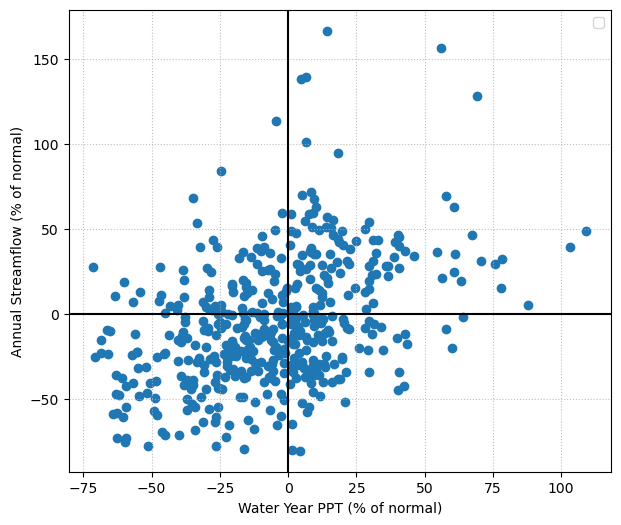

In [72]:
fig, ax = plt.subplots(figsize=(7,6))
ax.scatter(p_counter_factual,q_counter_factual)
# add regression line and label with slope

y = q_counter_factual.values.flatten()
x = p_counter_factual.values.flatten()[~np.isnan(y)]
y = y[~np.isnan(y)]
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
print(slope)
# ax.scatter(p_counter_factual.loc[2000:2022],q_counter_factual.loc[2000:2022])
ax.set_xlabel('Water Year PPT (% of normal)')
ax.set_ylabel('Annual Streamflow (% of normal)')
ax.grid(True, ls='dotted', alpha=0.8)
# ax.set_xlim(-120,120)
# ax.set_ylim(-120,120)
ax.axhline(0,ls='-',color='black')
ax.axvline(0,ls='-',color='black')
ax.legend()